# Wind Forcing comparision using INALT20
Here we explore the differences between the COREv2 and the JRA55-do wind forcing in the tropical Atlantic in INALT20.

## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import dask
from xorca.lib import load_xorca_dataset

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='00:45:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/xorca_env/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44597 instead
  warnings.warn(


In [3]:
from dask.distributed import Client

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://172.18.4.13:41517 Dashboard: http://172.18.4.13:44597/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Parameter preamble
Input

In [6]:
global_data_path = Path("../data/INALT20_taux_tauy_10S10N/")
JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model
region_str = '10S10N_65W15E'

# chunk sizes
chu_x = 100 # None means take the full dataset
chu_y = 100
chu_z = None
chu_t = 12

# define region fot western tropical Atlantic wind index
z_lim = []
x_lim = [-65, 15]
y_lim = [-10,10]

## Output preamble

In [7]:
#period for clim
t_cyc_min,t_cyc_max = '1980','2009' 

# bounds for longitudinal averages
dx=10
dy=4

lat_bins = np.arange(y_lim[0],y_lim[1]+dy/5,dy)

save_data_2deg_mm = True
save_data_mm = False #0 no data will be saved, 1 data will be saved
save_data_clim = False
save_data_anom = False
save_data_AM = False

# output data paths
out_dir_global = Path('../')
out_dir_data = Path(out_dir_global / 'data/INALT20_wind_forcing_comparison_tauy/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
script_name=  'INALT20_wind_forcing_comparison_tauy.ipynb'

#output figure paths
out_dir_fig = Path(out_dir_global / 'figures/INALT20_wind_forcing_comparison_tauy/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_file_fig1 = Path(f'INALT_JRA_CORE_tauy_anomaly_3S3N_40W10E_dx10')
out_file_fig2 = Path(f'INALT_JRA_minus_CORE_tauy_anomaly_3S3N_40W10E_dx10')
out_fig_hov_zo = Path(f'1_INALT_JRA_CORE_tauy_anomaly_hovm_zonal_')
out_fig_hov_me = Path(f'1_INALT_JRA_CORE_tauy_anomaly_hovm_merid_')
out_fig_hov_zo_clim = Path(f'1_INALT_JRA_CORE_tauy_clim_hovm_merid_')

fig_format = '.png'

# Find data files

In [8]:
JRA_files = list(sorted(
    (global_data_path).glob(
        f"{nest_prefix}{JRA_exp_id}{temp_res}*_*_grid_V.nc")
))

CORE_files = list(sorted(
    (global_data_path).glob(
        f"{nest_prefix}{CORE_exp_id}{temp_res}*_*_grid_V.nc"
    )
))


aux_files = list(sorted(
    (global_data_path).glob(f"{nest_prefix}[m,n]*.nc")
))
print(f"Found {len(aux_files)} mesh/mask files, {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")

Found 1 mesh/mask files, 52 CORE files and 61 JRA files.


## Open (virtual) model dataset

In [9]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})

## Functions

In [10]:
def load_data(fn,chu_t,chu_y,chu_x,ds_mesh):

    with dask.config.set(scheduler='synchronous'):
        ds_JRA = xr.open_dataset(
                fn,
                decode_cf=True,
                chunks={"time_counter":chu_t, 
                      "y":chu_y,"x":chu_x})

    ds_JRA = ds_JRA.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze()))
    ds_JRA = ds_JRA.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze()))
    ds_JRA = ds_JRA.assign_coords(vmask=(['y','x'],ds_mesh.vmaskutil.squeeze()))
    ds_JRA = ds_JRA.drop(['nav_lat','nav_lon'])
    ds_JRA.coords['lon'] = (('x'),ds_JRA.lon.isel(y=8))
    ds_JRA.coords['lat'] = (('y'),ds_JRA.lat.isel(x=100))
    ds_JRA=ds_JRA.swap_dims({'x':'lon','y':'lat'})
    return ds_JRA.sometauy.where(ds_JRA.vmask==1,drop=True)

    print(ds_JRA.nbytes/1e9,'GB')

def calc_mm_tau(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,fn):

    # upsample to daily for right weighting of monthly averages
    JRA_tauy_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tauy_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    JRA_tauy_ave = (JRA_tauy_ave_d*w).resample(time_counter = 'MS').sum().compute()
    JRA_tauy_ave.name = "tauy"
    JRA_tauy_ave.attrs['title'] = f"JRA tauy monthly mean"
    JRA_tauy_ave.attrs['expirement_id'] = JRA_exp_id
    JRA_tauy_ave.attrs['long_name']="Merid. Wind Stress"
    JRA_tauy_ave.attrs['units']="N/m2"
    JRA_tauy_ave.attrs['history']=f"Monthly mean calculated from {fn} using script {script_name}"
    JRA_tauy_ave.to_netcdf((out_dir_data / f"{fn.name[:20]}_mm_{fn.name[-52:]}"))

def reduce_lat_lon(ds,dxN,dyN):
    reduced = (
        ds
        .groupby(((ds.lon//dxN) + 0.5) * dxN)
        .mean(dim='lon')
        .groupby(((ds.lat//dyN) + 0.5) * dyN)
        .mean(dim='lat'))
    return reduced

def calc_mm_tau_reduce(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,fn):

    # upsample to daily for right weighting of monthly averages
    JRA_tauy_ave_d = ds_JRA.resample({'time_counter':'1D'},closed = 'right',label='right',loffset='-60H').nearest(tolerance='2D')           

    # Calculate the weights
    w = 1/JRA_tauy_ave_d.time_counter.dt.days_in_month

    # correct last weight (27-31 Dec = 5 days)
    w[-1] = 5/31

    # calulte monthly means weighted by days of each months
    JRA_tauy_ave = (JRA_tauy_ave_d*w).resample(time_counter = 'MS').sum().compute()
    JRA_tauy_ave.name = "tauy"
    JRA_tauy_ave.attrs['title'] = f" tauy coarse monthly mean"
    JRA_tauy_ave.attrs['expirement_id'] = JRA_exp_id
    JRA_tauy_ave.attrs['long_name']="Merid. Wind Stress"
    JRA_tauy_ave.attrs['units']="N/m2"
    JRA_tauy_ave.attrs['history']=f"Monthly mean, spatially averaged in 2deg bins calculated from {fn} using script {script_name}"
    JRA_tauy_ave.to_netcdf((out_dir_data / f"2deg_{fn.name[2:20]}_mm_{fn.name[-52:]}"))

def lon_str(xbnds):
    if xbnds[0]<0:
        min_str = f'{int(abs(xbnds[0]))}W'
    elif xbnds[0]>0:
        min_str = f'{int(abs(xbnds[0]))}E'
    else:
        min_str = ''

    if xbnds[1]<0:
        max_str = f'{int(abs(xbnds[1]))}W'
    elif xbnds[1]>0:
        max_str = f'{int(abs(xbnds[1]))}E'
    else:
        max_str = ''
    return min_str,max_str
        
def lat_str(xbnds):
    if xbnds[0]<0:
        min_str = f'{int(abs(xbnds[0]))}S'
    elif xbnds[0]>0:
        min_str = f'{int(abs(xbnds[0]))}N'
    else:
        min_str = ''

    if xbnds[1]<0:
        max_str = f'{int(abs(xbnds[1]))}S'
    elif xbnds[1]>0:
        max_str = f'{int(abs(xbnds[1]))}N'
    else:
        max_str = ''
        
    return min_str,max_str

## Load data and resample to monthly mean

In [16]:
%%time
if save_data_2deg_mm:
    dxN,dyN = 2,2
    for idx,yy in enumerate(range(1958,2019)):
        ds_JRA = load_data(JRA_files[idx],chu_t,chu_y,chu_x,ds_mesh)
        ds_JRA = reduce_lat_lon(ds_JRA.reset_coords(),dxN,dyN)
        ds_JRA = ds_JRA.set_coords('vmask').compute()
        calc_mm_tau_reduce(ds_JRA.sometauy,out_dir_data,nest_prefix,JRA_exp_id,JRA_files[idx])

        if yy<2010:
            ds_CORE = load_data(CORE_files[idx],chu_t,chu_y,chu_x,ds_mesh)
            ds_CORE.coords['time_counter']=ds_JRA.time_counter
            ds_CORE = reduce_lat_lon(ds_CORE.reset_coords(),dxN,dyN)
            ds_CORE = ds_CORE.set_coords('vmask').compute()
            calc_mm_tau_reduce(ds_CORE.sometauy,out_dir_data,nest_prefix,CORE_exp_id,CORE_files[idx])

CPU times: user 20min 22s, sys: 1min 29s, total: 21min 51s
Wall time: 48min 1s


## Orig grid

In [11]:
if save_data_mm:
    for idx,yy in enumerate(range(1958,2019)):
        ds_JRA = load_data(JRA_files[idx],chu_t,chu_y,chu_x,ds_mesh)
        calc_mm_tau(ds_JRA,out_dir_data,nest_prefix,JRA_exp_id,JRA_files[idx])

        if yy<2010:
            ds_CORE = load_data(CORE_files[idx],chu_t,chu_y,chu_x,ds_mesh)
            ds_CORE.coords['time_counter']=ds_JRA.time_counter
            calc_mm_tau(ds_CORE,out_dir_data,nest_prefix,CORE_exp_id,CORE_files[idx])

### Calculate Climatology 1980-2009

In [12]:
JRA_tau_fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}{JRA_exp_id}_mm_*_*_grid_V.nc")
))

CORE_tau_fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}{CORE_exp_id}_mm_*_*_grid_V.nc")
))

In [13]:
with dask.config.set(scheduler='synchronous'):
    JRA_tauy = xr.open_mfdataset(
            JRA_tau_fn,
            decode_cf=True,
            chunks={"time_counter":chu_t, 
                  "lat":chu_y,"lon":chu_x})
    CORE_tauy = xr.open_mfdataset(
            CORE_tau_fn,
            decode_cf=True,
            chunks={"time_counter":chu_t, 
                  "lat":chu_y,"lon":chu_x})

JRA_tauy = JRA_tauy.tauy.where(JRA_tauy.vmask==1,drop=True)
CORE_tauy = CORE_tauy.tauy.where(CORE_tauy.vmask==1,drop=True)

In [14]:
%%time
if save_data_clim:
        
    JRA_tauy_ave_clim = JRA_tauy.sel(time_counter=slice(t_cyc_min,t_cyc_max)).groupby('time_counter.month').mean('time_counter').compute()
    CORE_tauy_ave_clim = CORE_tauy.sel(time_counter=slice(t_cyc_min,t_cyc_max)).groupby('time_counter.month').mean('time_counter').compute()

    JRA_tauy_ave_clim.tauy.name = "tauy"
    JRA_tauy_ave_clim.attrs['title'] = f"JRA tauy clim {t_cyc_min}-{t_cyc_max}"
    JRA_tauy_ave_clim.attrs['expirement_id'] = JRA_exp_id
    JRA_tauy_ave_clim.attrs['long_name']="Merid. Wind Stress"
    JRA_tauy_ave_clim.attrs['units']="N/m2"
    JRA_tauy_ave_clim.attrs['history']=f"Monthly mean clim {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}{JRA_exp_id}_mm_*_*_grid_V.nc using script {script_name}"
    JRA_tauy_ave_clim.to_netcdf((out_dir_data / f"{nest_prefix}{JRA_exp_id[:-1]}X_JRA_tauy_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"))

    CORE_tauy_ave_clim.tauy.name = "tauy"
    CORE_tauy_ave_clim.attrs['title'] = f"CORE tauy clim {t_cyc_min}-{t_cyc_max}"
    CORE_tauy_ave_clim.attrs['expirement_id'] = CORE_exp_id
    CORE_tauy_ave_clim.attrs['long_name']="Merid. Wind Stress"
    CORE_tauy_ave_clim.attrs['units']="N/m2"
    CORE_tauy_ave_clim.attrs['history']=f"Monthly mean clim {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}{CORE_exp_id}_mm_*_*_grid_V.nc using script {script_name}"
    CORE_tauy_ave_clim.to_netcdf((out_dir_data / f"{nest_prefix}{CORE_exp_id}_CORE_tauy_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


# Plot data

In [15]:
with dask.config.set(scheduler='synchronous'):
    JRA_tauy_ave_clim = xr.open_dataarray(
        (out_dir_data / f"{nest_prefix}{JRA_exp_id[:-1]}X_JRA_tauy_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"),
            decode_cf=True,
            chunks={"lat":chu_y,"lon":chu_x})
    CORE_tauy_ave_clim = xr.open_dataarray(
        (out_dir_data / f"{nest_prefix}{CORE_exp_id}_CORE_tauy_mm_clim_{region_str}_{t_cyc_min}_{t_cyc_max}.nc"),
            decode_cf=True,
            chunks={"lat":chu_y,"lon":chu_x})

JRA_tauy_ave_clim = JRA_tauy_ave_clim.where(JRA_tauy_ave_clim.vmask==1,drop=True)
CORE_tauy_ave_clim = CORE_tauy_ave_clim.where(CORE_tauy_ave_clim.vmask==1,drop=True)

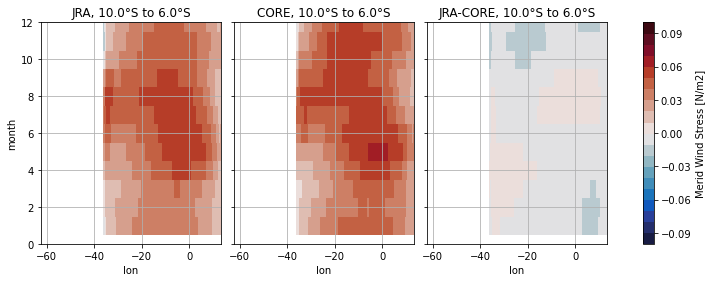

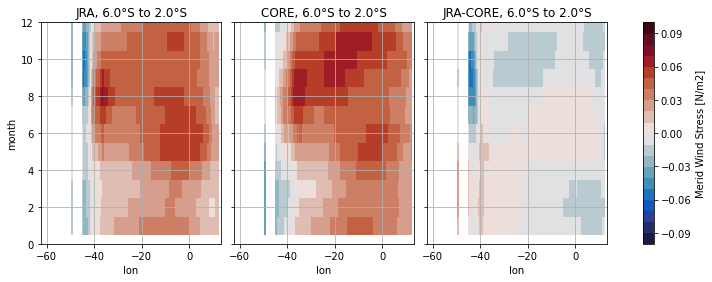

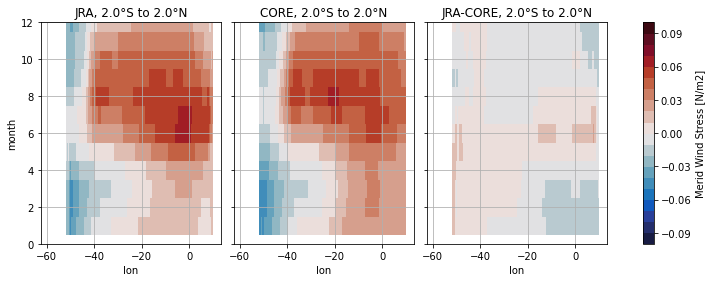

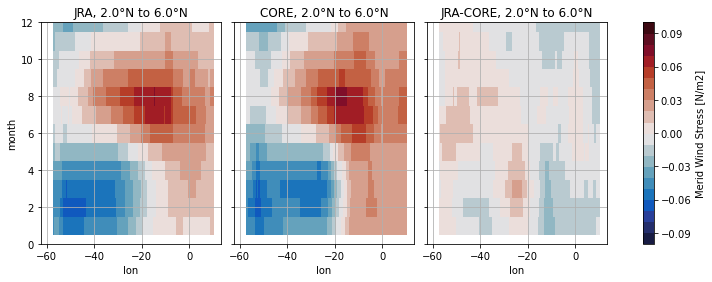

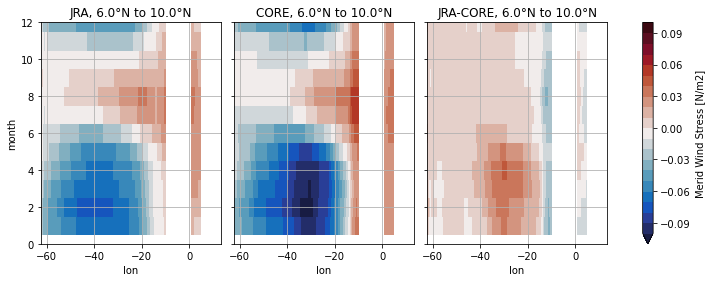

In [16]:
with xr.set_options(keep_attrs=True):
    tau_clim = xr.concat([JRA_tauy_ave_clim,CORE_tauy_ave_clim,(JRA_tauy_ave_clim-CORE_tauy_ave_clim)],
                        'forcings')
tau_clim.coords['forcing'] = (['forcings'],['JRA','CORE','JRA-CORE'],)

for kk,val in enumerate(lat_bins[:-1]):

    y_lim=lat_bins[kk:kk+2]
    s_str,n_str=lat_str(y_lim)

    ds_dummy=tau_clim.sel(lat=slice(y_lim[0],y_lim[1]))
    
    ds_dummy.name = 'Merid Wind Stress [N/m2]'
    
    p = ds_dummy.mean('lat').plot(
        x='lon',y='month',col='forcings',col_wrap=3,
        ylim=[0,12],aspect=.8, size=4,
        levels=21,vmin=-0.1,vmax=0.1,
        cmap=co.cm.balance)

    for idx,ax in enumerate(p.axes.flat):
        ax.grid()
        ax.set_title('%.10s, ' %tau_clim.forcing[idx].values 
                     +str(np.abs(y_lim[0]))+'\N{DEGREE SIGN}'+s_str[-1]+' to '
                     +str(np.abs(y_lim[1]))+'\N{DEGREE SIGN}'+n_str[-1])
    
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_zo_clim}{t_cyc_min}_{t_cyc_max}_{s_str}{n_str}{fig_format}"),dpi=300)

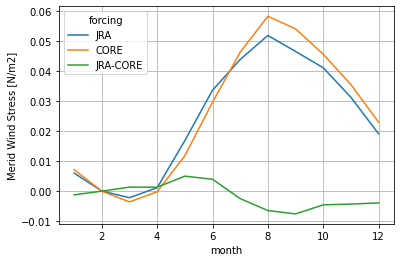

In [17]:
ds_dummy = tau_clim.sel(lat=slice(-3,3),lon=slice(-30,-20)).mean(['lat','lon'])
ds_dummy.name = 'Merid Wind Stress [N/m2]'
ds_dummy.plot.line(x='month',hue='forcing')
plt.grid()

### Calculate wind stress anomlies with respect to climatology {t_cyc_min}-{t_cyc_max}

In [18]:
%%time
if save_data_anom:
    for yy in range(2010,2019):
        year = str(yy)
        JRA_tauy_mmA = JRA_tauy.sel(time_counter=year).groupby('time_counter.month') - JRA_tauy_ave_clim
        
        if yy<2010:
            CORE_tauy_mmA= CORE_tauy.sel(time_counter=year).groupby('time_counter.month') - CORE_tauy_ave_clim
        else:
            CORE_tauy_mmA= CORE_tauy.sel(time_counter='2009')*np.NaN 
            CORE_tauy_mmA.coords['time_counter'] = JRA_tauy_mmA.time_counter

        tauy_mmA =xr.merge([
            JRA_tauy_mmA.rename('JRA_tauy'),
            CORE_tauy_mmA.rename('CORE_tauy')
            ])

        tauy_mmA.attrs['title']=f"INALT20 mm merid wind stress anomalies relto {t_cyc_min}-{t_cyc_max} [N/m2]"
        tauy_mmA.lon.attrs['standard_name'] = 'longitude'
        tauy_mmA.lon.attrs['long_name'] = "Longitude"
        tauy_mmA.lon.attrs['units'] = 'degrees_east'
        tauy_mmA.lat.attrs['standard_name'] = 'latitude'
        tauy_mmA.lat.attrs['long_name'] = "Latitude"
        tauy_mmA.lat.attrs['units'] = 'degrees_north'
        tauy_mmA.JRA_tauy.attrs['long_name'] = 'Merid wind stress anomaly'
        tauy_mmA.JRA_tauy.attrs['expirement_id'] = JRA_exp_id
        tauy_mmA.CORE_tauy.attrs['long_name'] = 'Merid wind stress anomaly'
        tauy_mmA.CORE_tauy.attrs['expirement_id'] = CORE_exp_id
        tauy_mmA.JRA_tauy.attrs['units'] = 'N/m2'
        tauy_mmA.CORE_tauy.attrs['units'] = 'N/m2'
        tauy_mmA.attrs['contact'] = 'Kristin Burmeister - kristin.burmeister@sams.ac.uk'
        tauy_mmA.attrs['history'] = f"Monthly mean anom relto {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}*_mm_[clim_]*_*_grid_V.nc using script {script_name}"
        display(tauy_mmA)
        tauy_mmA.to_netcdf((out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_{year}_tauy_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                    engine = 'netcdf4')

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10.5 µs


In [19]:
fn = list(sorted(
    (out_dir_data).glob(
        f"{nest_prefix}INALT20_JRA_CORE_????_tauy_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"
)))

with dask.config.set(scheduler='synchronous'):
        tauy_mmA = xr.open_mfdataset(
                fn,
                decode_cf=True,
                chunks={"time_counter":chu_t, 
                      "lat":chu_y,"lon":chu_x})

## Calculate annual averages

In [20]:
%%time
if save_data_AM:
    tauy_AM_anom= tauy_mmA.groupby('time_counter.year').mean('time_counter').compute()
    tauy_AM_anom.lon.attrs['standard_name'] = 'longitude'
    tauy_AM_anom.lon.attrs['long_name'] = "Longitude"
    tauy_AM_anom.lon.attrs['units'] = 'degrees_east'
    tauy_AM_anom.lat.attrs['standard_name'] = 'latitude'
    tauy_AM_anom.lat.attrs['long_name'] = "Latitude"
    tauy_AM_anom.lat.attrs['units'] = 'degrees_north'
    tauy_AM_anom.JRA_tauy.attrs['long_name'] = 'Merid wind stress anomaly'
    tauy_AM_anom.JRA_tauy.attrs['expirement_id'] = JRA_exp_id
    tauy_AM_anom.CORE_tauy.attrs['long_name'] = 'Merid wind stress anomaly'
    tauy_AM_anom.CORE_tauy.attrs['expirement_id'] = CORE_exp_id
    tauy_AM_anom.JRA_tauy.attrs['units'] = 'N/m2'
    tauy_AM_anom.CORE_tauy.attrs['units'] = 'N/m2'
    tauy_AM_anom.attrs['title'] = f'INALT20 Merid wind stress anomalies relto {t_cyc_min}-{t_cyc_max}'
    tauy_AM_anom.attrs['contact'] = 'Kristin Burmeister - kristin.burmeister@sams.ac.uk'
    tauy_AM_anom.attrs['history'] = f"Annual mean anom relto {t_cyc_min}-{t_cyc_max} calculated from {out_dir_data}/{nest_prefix}*_mm_[clim_]*_*_grid_V.nc using script {script_name}"
    tauy_AM_anom.to_netcdf((out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_AM_tauy_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                    engine = 'netcdf4')
else:
    with dask.config.set(scheduler='synchronous'):
        tauy_AM_anom = xr.open_dataset(
                (out_dir_data / f"{nest_prefix}INALT20_JRA_CORE_AM_tauy_mmA_{region_str}_clim_{t_cyc_min}_{t_cyc_max}.nc"),
                decode_cf=True,
                chunks={"lat":chu_y,"lon":chu_x})
        
tauy_AM_anom

CPU times: user 11.8 ms, sys: 924 µs, total: 12.7 ms
Wall time: 68.7 ms


<xarray.Dataset>
Dimensions:    (lat: 403, lon: 1516, year: 61)
Coordinates:
  * lat        (lat) float32 -9.974 -9.925 -9.876 -9.826 ... 9.925 9.974 10.02
  * lon        (lon) float32 -62.35 -62.3 -62.25 -62.2 ... 13.25 13.3 13.35 13.4
    vmask      (lat, lon) int8 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * year       (year) int64 1958 1959 1960 1961 1962 ... 2015 2016 2017 2018
Data variables:
    JRA_tauy   (year, lat, lon) float64 dask.array<chunksize=(61, 100, 100), meta=np.ndarray>
    CORE_tauy  (year, lat, lon) float64 dask.array<chunksize=(61, 100, 100), meta=np.ndarray>
Attributes:
    title:    INALT20 Merid wind stress anomalies relto 1980-2009
    contact:  Kristin Burmeister - kristin.burmeister@sams.ac.uk
    history:  Annual mean anom relto 1980-2009 calculated from ../data/INALT2...

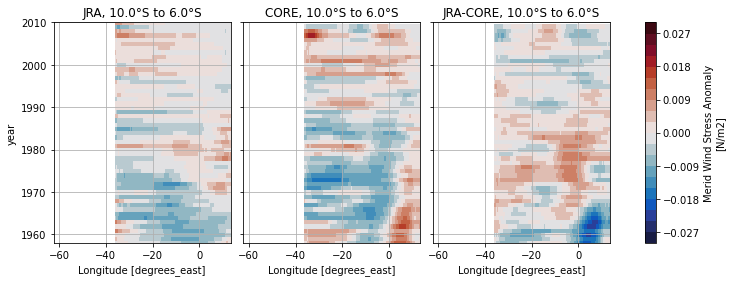

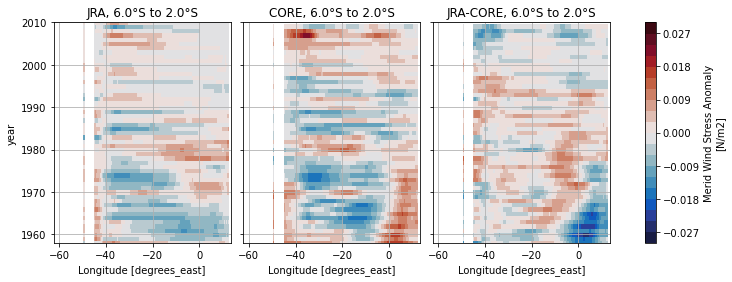

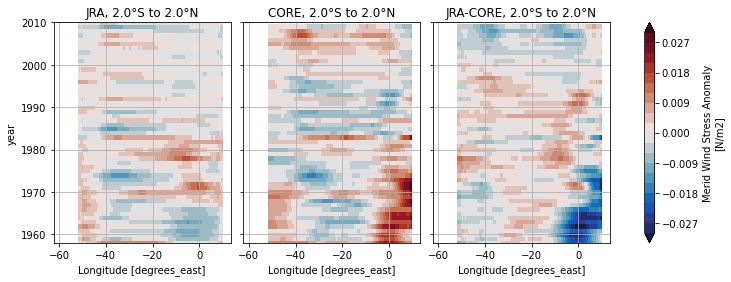

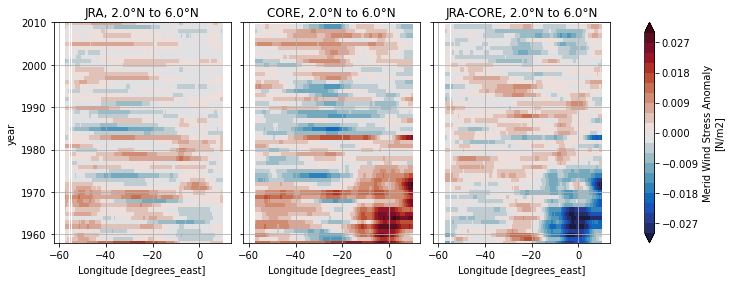

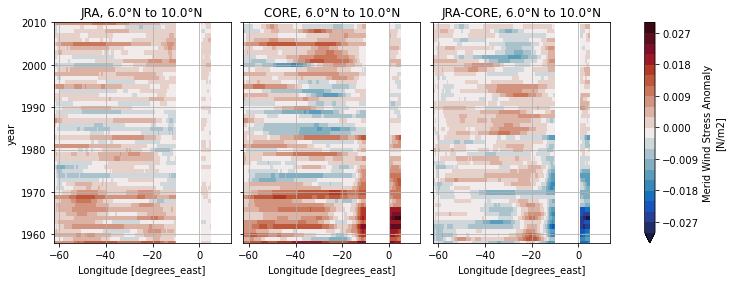

In [21]:
with xr.set_options(keep_attrs=True):
    ds_test = xr.concat([tauy_AM_anom.JRA_tauy,tauy_AM_anom.CORE_tauy,(tauy_AM_anom.JRA_tauy-tauy_AM_anom.CORE_tauy)],
                        'forcings')
ds_test.coords['forcing_str'] = (['forcings'],['JRA','CORE','JRA-CORE'],)

for kk,val in enumerate(lat_bins[:-1]):

    y_lim=lat_bins[kk:kk+2]
    s_str,n_str = lat_str(y_lim)

    ds_t=ds_test.sel(lat=slice(y_lim[0],y_lim[1]))
    
    ds_t.name = 'Merid Wind Stress Anomaly [N/m2]'
    
    p = ds_t.mean('lat').plot(
        x='lon',y='year',col='forcings',col_wrap=3,
        ylim=[1958,2010],aspect=.8, size=4,
        levels=21,vmin=-0.03,vmax=0.03,
        cmap=co.cm.balance)

    for idx,ax in enumerate(p.axes.flat):
        ax.grid()
        ax.set_title('%.10s, ' %ds_test.forcing_str[idx].values
                     +str(np.abs(y_lim[0]))+'\N{DEGREE SIGN}'+s_str[-1]+' to '
                     +str(np.abs(y_lim[1]))+'\N{DEGREE SIGN}'+n_str[-1])
    
  
    plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_zo}{s_str}{n_str}{fig_format}"),dpi=300)

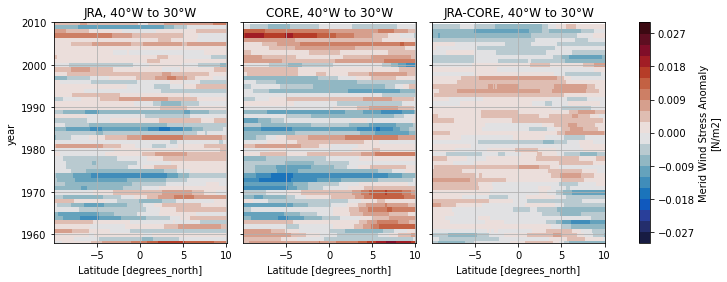

In [22]:
xbnds = [-40,-30]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Merid Wind Stress Anomaly [N/m2]'

p = ds_t.plot(
    x='lat',y='year',col='forcings',col_wrap=3,
    ylim=[1958,2010],aspect=.8, size=4,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcing_str[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300)

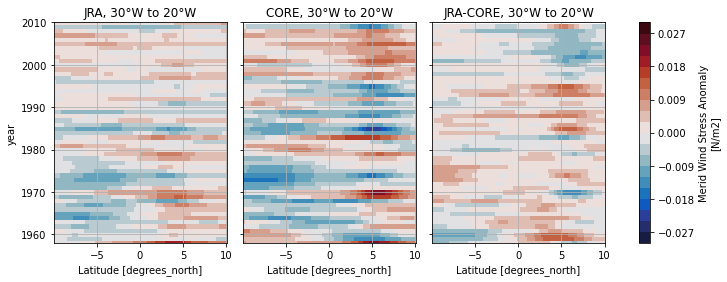

In [23]:
xbnds = [-30,-20]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Merid Wind Stress Anomaly [N/m2]'

p = ds_t.plot(
    x='lat',y='year',col='forcings',col_wrap=3,
    ylim=[1958,2010],aspect=.8, size=4,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcing_str[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300)

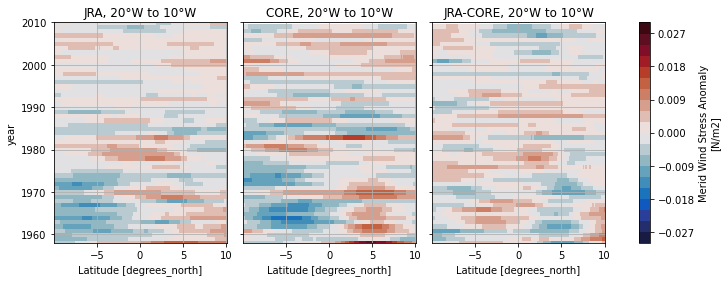

In [24]:
xbnds = [-20,-10]
min_str,max_str = lon_str(xbnds)

ds_t=ds_test.sel(lon=slice(xbnds[0],xbnds[1])).mean('lon')

ds_t.name = 'Merid Wind Stress Anomaly [N/m2]'

p = ds_t.plot(
    x='lat',y='year',col='forcings',col_wrap=3,
    ylim=[1958,2010],aspect=.8, size=4,
    levels=21,vmin=-0.03,vmax=0.03,
    cmap=co.cm.balance)

for idx,ax in enumerate(p.axes.flat):
    ax.grid()
    ax.set_title('%.10s, ' %ds_test.forcing_str[idx].values 
                     +str(np.abs(xbnds[0]))+'\N{DEGREE SIGN}'+min_str[-1]+' to '
                     +str(np.abs(xbnds[1]))+'\N{DEGREE SIGN}'+max_str[-1])

plt.savefig((out_dir_fig / f"{nest_prefix}{out_fig_hov_me}{min_str}{max_str}{fig_format}"),dpi=300)

In [34]:
da = ds_test.sel(lat=slice(-3,3),lon=slice(-40,9))
da = (da
      .mean('lat')
      .groupby(((da.lon//10) + 0.5) * 10)
      .mean(dim='lon'))
da = da.rename({'forcing_str':'forcings'})
da

<xarray.DataArray 'JRA_tauy' (forcings: 3, year: 61, lon: 5)>
dask.array<transpose, shape=(3, 61, 5), dtype=float64, chunksize=(1, 61, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -35.0 -25.0 -15.0 -5.0 5.0
  * year      (year) int64 1958 1959 1960 1961 1962 ... 2014 2015 2016 2017 2018
  * forcings  (forcings) <U8 'JRA' 'CORE' 'JRA-CORE'

<Figure size 432x288 with 0 Axes>

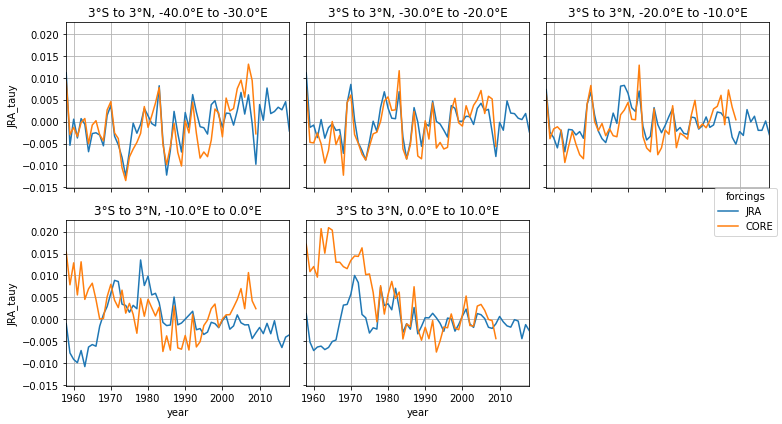

In [35]:
fig = plt.figure()
p=da.sel(forcings=['JRA','CORE']).plot.line(
    x='year',col='lon',
    col_wrap=3,sharey=True,
    xlim=[1958,2018])

for idx,ax in enumerate(p.axes.flat[:-1]):
    ax.set_title('3\N{DEGREE SIGN}S to 3\N{DEGREE SIGN}N, '
                 +str(np.array(da.lon[idx])-5)
                 +'\N{DEGREE SIGN}E to '
                 +str(np.array(da.lon[idx])+5)
                 +'\N{DEGREE SIGN}E')
    ax.grid();
    
plt.tight_layout()
plt.savefig((out_dir_fig / f"{nest_prefix}{out_file_fig1}{fig_format}"),dpi=300)

<Figure size 432x288 with 0 Axes>

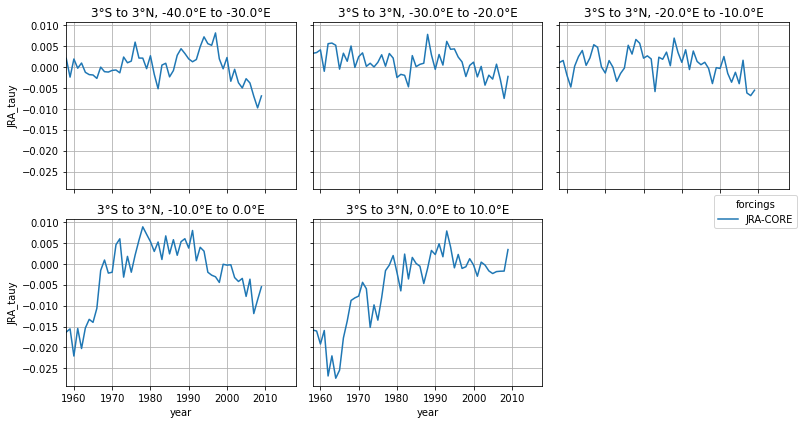

In [36]:
fig = plt.figure()
p=da.sel(forcings=['JRA-CORE']).plot.line(
    x='year',col='lon',
    col_wrap=3,sharey=True,
    xlim=[1958,2018])

for idx,ax in enumerate(p.axes.flat[:-1]):
    ax.set_title('3\N{DEGREE SIGN}S to 3\N{DEGREE SIGN}N, '
                 +str(np.array(da.lon[idx])-5)
                 +'\N{DEGREE SIGN}E to '
                 +str(np.array(da.lon[idx])+5)
                 +'\N{DEGREE SIGN}E')
    ax.grid();
    
plt.tight_layout()
plt.savefig((out_dir_fig / f"{nest_prefix}{out_file_fig2}{fig_format}"),dpi=300)

Differences in multidecadal variability increases towards the east. Which region is more important in driving current variability?

But only for the period before 1990 - afterwards they agree quite well in the easter basin, whereas, at approxiately the same time (late 1990s), they begin to deviate from each other in the western boxes.